# TP1 Simulación

## Ejercicio 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from statistics import mean, variance

def own_rand():
    own_rand.x_n = (own_rand.x_n * 1013904223 + 1664525) % (2 ** 32)
    return own_rand.x_n
own_rand.x_n = (97811 + 97811 + 97811)/3


In [3]:
result_1a = [own_rand() for i in range(6)]
result_1a

[192755738, 1392371123, 1950649466, 726488403, 2540951770, 1889127667]

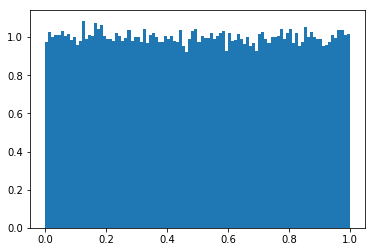

In [4]:
def own_rand_u():
    return float(own_rand())/(2**32)

def rand_u_vector(n):
    return [own_rand_u() for i in range(n)]
result_1b = rand_u_vector(10**5)
plt.hist(result_1b, bins=100, density=True)
plt.show()

## Ejercicio 2

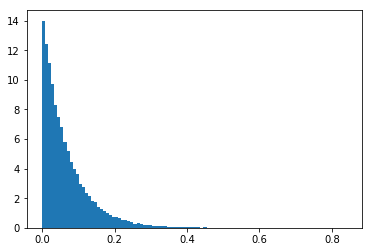

In [5]:
def make_exponential_dist_inverse(lamda):
    def inverse_dist(u):
        return -math.log(u)/lamda
    return inverse_dist

inverse_dist = make_exponential_dist_inverse(15)
inverse_dist = np.vectorize(inverse_dist)

exponential_sample = inverse_dist(rand_u_vector(10**5))

bins_values, bins_edges, _ = plt.hist(exponential_sample,bins=100, density=True)
bins_exp = zip(bins_values, bins_edges[:-1])
plt.show()

In [6]:
mean_exp = mean(exponential_sample)
mode_exp = max(bins_exp, key=(lambda x: x[0]))[1] # Use the first argument as the key to be maxed but return the left edge of the bin which it belongs to
variance_exp = variance(exponential_sample, mean_exp)
mean_exp, mode_exp, variance_exp

(0.066778600800960042, 3.0159397593723117e-07, 0.0044907840818437742)

## Ejercicio 3

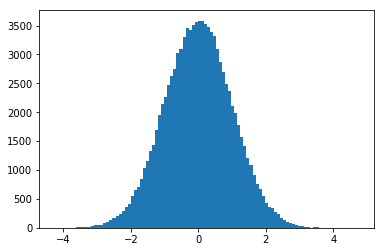

In [7]:
def make_normal_dist_inverse(mu, sigma):
    def inverse_dist(u):
        return norm.ppf(u) * sigma + mu
    return inverse_dist

normal_inverse_dist = make_normal_dist_inverse(0, 1)
normal_inverse_dist = np.vectorize(normal_inverse_dist)
normal_sample = normal_inverse_dist(rand_u_vector(10**5))
bins_values, bins_edges, _ = plt.hist(normal_sample, bins=100)
bins_normal = zip(bins_values, bins_edges[:-1])
plt.show()

In [8]:
mean_normal = mean(normal_sample)
mode_normal = max(bins_normal, key=(lambda x: x[0]))[1] # Use the first argument as the key to be maxed but return the left edge of the bin which it belongs to
variance_modal = variance(normal_sample, mean_normal)
mean_normal, mode_normal, variance_modal

(-0.0025676630876154951, 0.071585346507109904, 0.99421780363166878)

***Nota: Comparada con los valores esperados (0, 0 y 1), los valores generados son bastantes cercanos.***

## Ejercicio 4

  En este ejercicio debemos simular una variable aleatoria, X, con distribución N(med=35,stddev=5) a través del metodo de acepto-rechazo.

  Para hacer esto primero simularemos |Z| donde Z es una variable aleatoria de distribución N(0,1). Luego, multiplicaremos con probabilidad igual a 1/2 a |Z| por -1, con esto logramos obtener otra variable aleatoria con una distribución igual a la de Z. Finalmente, multiplicaremos esta ultima variable aleatoria por 5 y luego le sumaremos 35 para obtener la variable finalmente deseada, X.
  
  Para obtener |Z| es donde se utilizara el metodo acepto-rechazo. Para ello utilizaremos una variable aleatoria exponencial. Por lo tanto, primeramente debemos calcular c / pdf_|Z| (x) <= c * pdf_E(x) para todo x. Con unas pocas cuentas se obtiene que la c minima que cumple esto es 1.32 aprox.  

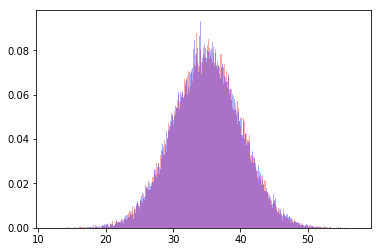

In [9]:
lamda = 1
c = 1.32

def norm_pdf(x, loc, scale):
    return norm.pdf(x, loc=loc, scale=scale)

def random_exp(lamda):
    exponential_dist_inverse = make_exponential_dist_inverse(lamda)
    return exponential_dist_inverse(own_rand_u())

def make_exp_pdf(lamda):
    def exp_pdf(x):
        return lamda * math.exp(-lamda * x)
    return exp_pdf

own_exp_pdf = make_exp_pdf(lamda)

def make_norm_acc_rej(loc=0, scale=1):
    def norm_acc_rej():
        start = True
        while start or y > norm_pdf(x, 0, 1):
            start = False
            x = random_exp(lamda)
            y = own_rand_u() * c * own_exp_pdf(x)
            sign = 1 if own_rand_u() < 0.5 else -1
        return x * scale * sign + loc
    return norm_acc_rej

def norm_acc_rej_vector(qty, loc=0, scale=1):
    own_acc_rej = make_norm_acc_rej(loc, scale)
    return [own_acc_rej() for i in range(qty)]

normal_sample2 = norm_acc_rej_vector(10**5, 35, 5)

bins_values, bins_edges, _ = plt.hist(normal_sample2, bins=1000, color='#ff000055', density=True)
bins_normal = zip(bins_values, bins_edges[:-1])

normal_control_group = [np.random.normal() * 5 + 35 for i in range(10**5)]
plt.hist(normal_control_group, bins=1000, color='#0000ff55', density=True)
                                    
plt.show()


In [10]:
mean_normal2 = mean(normal_sample2)
mode_normal2 = max(bins_exp, key=(lambda x: x[0]))[1] # Use the first argument as the key to be maxed but return the left edge of the bin which it belongs to
variance_normal2 = variance(normal_sample2, mean_normal2)
mean_normal2, mode_normal2, variance_normal2

(35.02352997620988, 3.0159397593723117e-07, 25.028608678627627)

Los valores dados coinciden con los esperados (35, 0, 25)

# Ejercicio 5



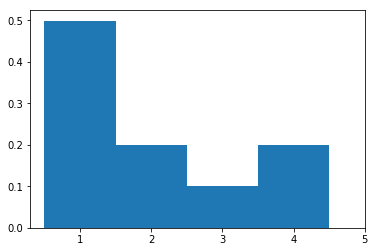

In [11]:
def empiric_inv_distribution(u):
    if u <= 0.5:
        return 1
    elif u <= 0.7:
        return 2
    elif u <= 0.8:
        return 3
    else:
        return 4
    
def gen_empiric():
    return empiric_inv_distribution(own_rand_u())

empiric_sample = [gen_empiric() for i in range(10**5)]


bins_empiric = np.arange(0.5, 5.5, 1)

plt.hist(empiric_sample, bins=bins_empiric, density=True)
plt.xticks(np.arange(1,6,1))
plt.show()

## Ejercicio 6


- Cada lanzamiento de la moneda se puede modelar con una variable aleatoria de distribución Bernoulli. 
- El experimento de lanzar una moneda se puede modelar como una variable aleatoria de distribución Geometrica.


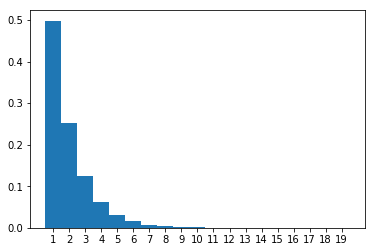

In [12]:
def bernoulli_random():
    return 1 if own_rand_u() < 0.5 else 0

def geometric_random():
    qty = 1
    while bernoulli_random() != 1:
        qty += 1
    return qty

geometric_sample = [geometric_random() for i in range(10**5)]

bins_geometric = np.arange(0.5, 20, 1)

plt.hist(geometric_sample, bins=bins_geometric, density=True)
plt.xticks(np.arange(1,20,1))
plt.show()

## Ejercio 7

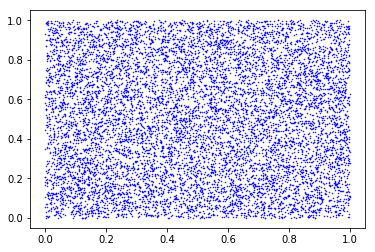

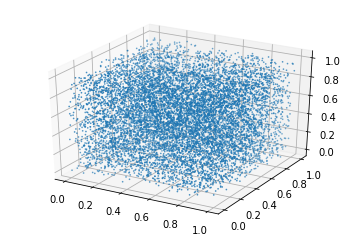

In [13]:
from mpl_toolkits.mplot3d import Axes3D
uniform_random_sample = rand_u_vector(10**4)
uniform_random_sample_x = uniform_random_sample[:-2]
uniform_random_sample_y = uniform_random_sample[1:-1]
uniform_random_sample_z = uniform_random_sample[2:]



plt.plot(uniform_random_sample_x, uniform_random_sample_y, 'bo', markersize=0.5)
plt.show()

ax = plt.subplot(111, projection='3d')
ax.scatter(uniform_random_sample_x, uniform_random_sample_y, uniform_random_sample_z, s=0.5)
plt.show()

A simple vista los puntos se distribuyen uniformemente tanto en 2D como en 3D.


## Ejercicio 8

In [14]:
from collections import Counter
from scipy.stats import chi2

def geometric_prob(q, n):
    return math.pow(q, n-1) * (1-q)

def t(significance, dof):
    return chi2.ppf(significance, dof)
    
def d_func(geometric_sample):
    N = Counter(geometric_sample)
    npi = {n : len(geometric_sample) * geometric_prob(0.5, n) for n in N.keys()}
    result = 0
    for i in N.keys():
        result += math.pow(N[i] - npi[i], 2) / npi[i]
    return result

if d_func(geometric_sample) < t(0.01, len(geometric_sample)):
    print('Los datos responden a una distribucion geometrica')
else:
    print('Los datos no responden a una distribucion geometrica')

Los datos responden a una distribucion geometrica


In [15]:
# Ejercicio 9

In [16]:
# Ejercicio 10

In [77]:
def real_cdf_uniform(x, min_value=0, max_value=1):
    if x < min_value:
        return 0
    if x > max_value:
        return 1
    return float(x - min_value) / max_value

def calc_max_D(sample, theoric_cdf):
    max_D = 0
    ctr = 0
    sample_size = len(sample)
    for x in sorted(sample):
        empiric_cdf_left_limit = float(ctr) / sample_size
        empiric_cdf_right_limit = float(ctr + 1) / sample_size 
        theoric_value = theoric_cdf(x)
        max_D = max(max_D,
                   math.fabs(empiric_cdf_left_limit - theoric_value),
                   math.fabs(empiric_cdf_right_limit - theoric_value))
        ctr += 1
        
    return max_D

sample = rand_u_vector(10**4)

D = calc_max_D(sample, real_cdf_uniform)
D

0.010087574468925609

In [78]:
# According to https://modsim141.wordpress.com/2016/09/26/laboratorio3-kolmogorov-smirnov/ we need D to be less than 
# 1.63/sqrt(n)


if D < 1.63 / math.sqrt(len(sample)):
    print 'Acepto que sea uniforme'
else:
    print 'Rechazo que sea uniforme'


Acepto que sea uniforme
